### Section 5.3, Connection to Compressed Sensing, page 14.

- Single frame video sequence == single image, problem is reduced to compressed sensing.
- Here, we compare performance of conditional and unconditional Langevin sampling.

In [1]:
import numpy as np
from numpy.random import default_rng
rng = default_rng(0)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (15,15)

In [3]:
# X ~ N(x; mu, sigma)
# Generate single frame video sequence (32 x 32) image with 2 colour channels.
shape = (32, 32)
rng = default_rng()

mu = np.array([3, 5])
sigma = np.eye(mu.shape[0]) * 3
data = rng.multivariate_normal(mean=mu, cov=sigma, size=shape)

data.shape

(32, 32, 2)

In [23]:
# Generate y = Ax, where A is sub-sampling mask

mask = rng.integers(0, 2, shape)[..., None]
mask = mask.repeat(2, -1)
meas = mask * data

bool_mask = np.ma.make_mask(mask[..., 0]) # Boolean mask to extract observed/unmasked datapoints only

meas.shape

(32, 32, 2)

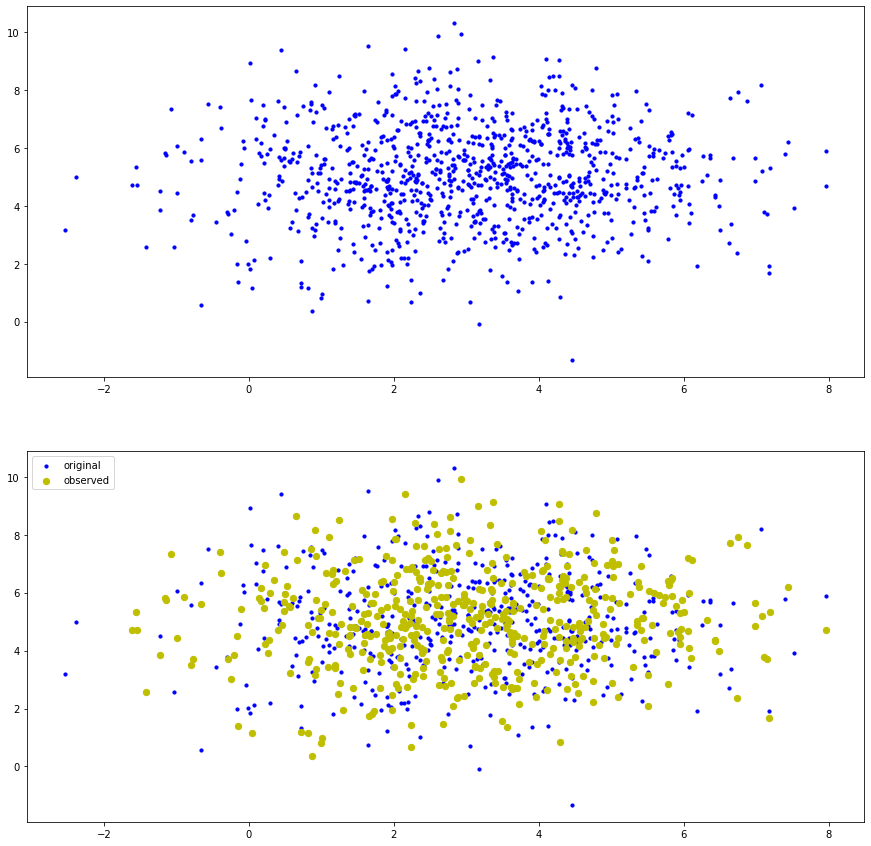

In [24]:
# Diagram above shows overall distribution of generated samples.
# Diagram below highlights UNMASKED/OBSERVED data points of the single image in yellow

def scatter_plot(data, meas):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    
    x_vec = np.ravel(data[:, :, 0])
    y_vec = np.ravel(data[:, :, 1])
    ax1.scatter(x_vec,y_vec, s=10, c='b', marker="o", label='original')
    ax2.scatter(x_vec,y_vec, s=10, c='b', marker="o", label='original')
    
    x_vec = np.ravel(data[:, :, 0][bool_mask])
    y_vec = np.ravel(data[:, :, 1][bool_mask])
    ax2.scatter(x_vec,y_vec, s=40, c='y', marker="o", label='observed', facecolor='none')
    plt.legend(loc='upper left')

scatter_plot(data, meas)

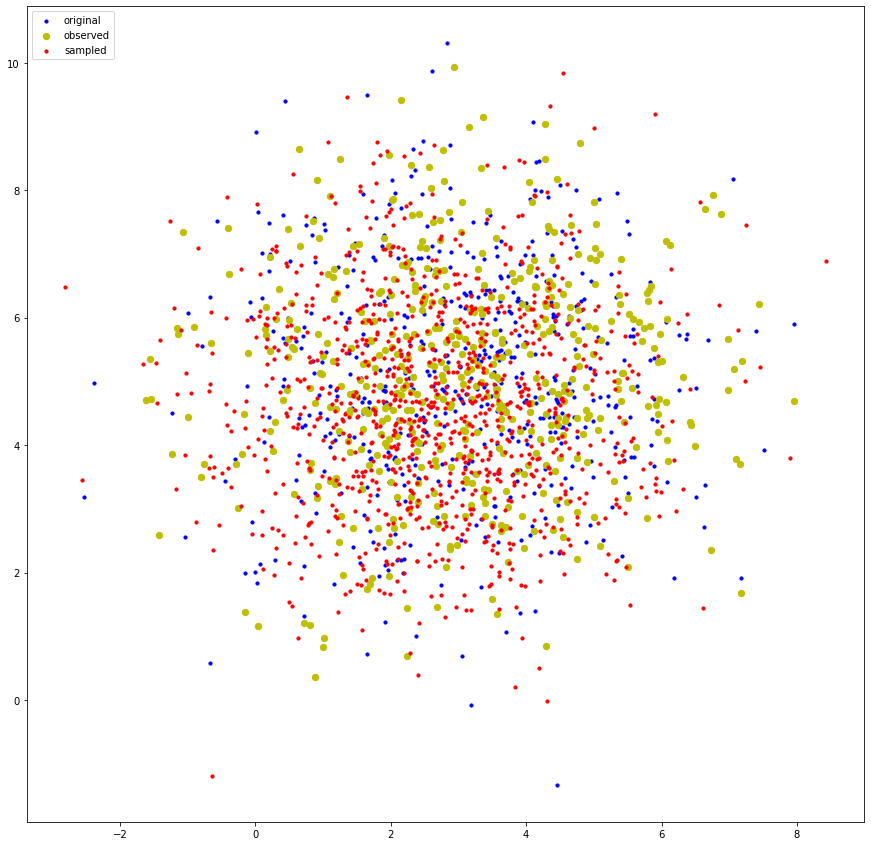

In [25]:
# Apply unconditional Langevin sampling to recover the original (generated) data
# Datapoints highlighted in RED represents sampled datapoints.

def get_score_normal(x):
    sigma = np.array([3, 3])
    mu = np.array([3, 5])
    score = (x - mu[None, None, :]) / sigma[None, None, :]
    return -1 * score 

      
def uncond_langevin_sampler(step_size=0.01):
    mean = np.array([0, 0])
    cov = np.eye(mean.shape[0])
    x = np.zeros(shape)[:, :, None]
    x = np.repeat(x, 2, -1)
    
    for _ in range(1500):
        score = get_score_normal(x)
        x = x + step_size * score / 2 + np.sqrt(step_size) * rng.multivariate_normal(mean=mean, cov=cov, size=shape)
    
    return x


def scatter_plot(data, sampled, meas):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    x_vec = np.ravel(data[:, :, 0])
    y_vec = np.ravel(data[:, :, 1])
    ax1.scatter(x_vec,y_vec, s=10, c='b', marker="o", label='original')
    
    x_vec = np.ravel(meas[:, :, 0][bool_mask])
    y_vec = np.ravel(meas[:, :, 1][bool_mask])
    ax1.scatter(x_vec,y_vec, s=40, c='y', marker="o", label='observed', facecolor='none')
    
    x_vec = np.ravel(sampled[:, :, 0])
    y_vec = np.ravel(sampled[:, :, 1])
    ax1.scatter(x_vec,y_vec, s=10, c='r', marker="o", label='sampled', facecolor='none')
        
    plt.legend(loc='upper left')

x_hat = uncond_langevin_sampler()
scatter_plot(data, x_hat, meas)

# Notice how the red points (sampled) are inconsistent with the blue/yellow (original) points,
# although the red points still follows the original data distribution (Gaussian).

# Ideally, we want the red points to lie DIRECTLY above the blue/yellow points.


(1024,)


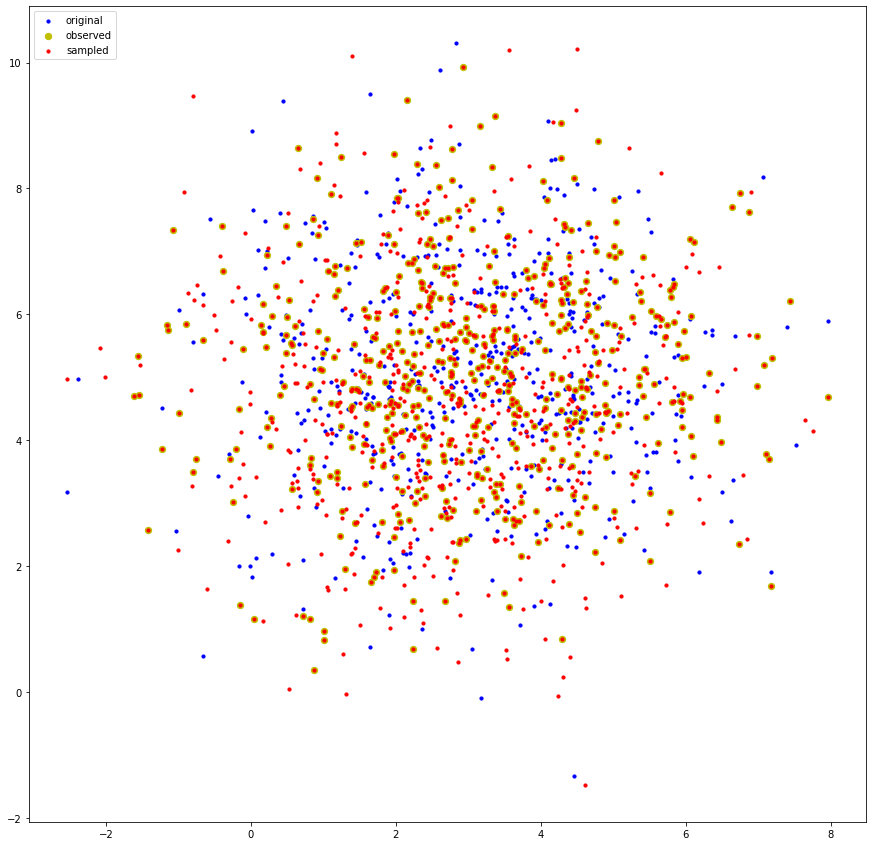

In [26]:
# Apply conditional Langevin sampling to recover the original (generated) data
# Datapoints highlighted in RED represents sampled datapoints.

def proximal(meas, mask, x):
    def A(mask, x):
        return np.sum(mask * x, axis=0)
    
    def At(mask, y):
        res = np.zeros_like(mask)
        for n in range(mask.shape[0]):
            res[n] = np.multiply(y, mask[n])
        return res
    
    mask = mask[None, ...]
    mask_sum = np.sum(mask, axis=0)
    mask_sum[mask_sum == 0] = 1
    x = x[None, ...]
    
    temp = A(mask, x)
    temp = x + np.divide(meas - temp, mask_sum)
    return temp[0]

def get_scores(x, mask, meas):
    sigma = np.array([3, 3])
    mu = np.array([3, 5])
    score_x = (x - mu[None, None, :]) / sigma[None, None, :]
    # score_yx = (meas - mask * x) / sigma[None, None, :]
    # return -1 * (score_x + score_yx)
    return -1 * score_x

def cond_langevin_sampler(mask, meas, step_size=0.01, alpha=0.001):
    mean = np.array([0, 0])
    cov = np.eye(mean.shape[0])
    x = np.zeros(shape)[:, :, None]
    x = np.repeat(x, 2, -1)
    
    for _ in range(1500):
        scores = get_scores(x, mask, meas)
        x = x + step_size * scores / 2
        noise = np.sqrt(step_size) * rng.multivariate_normal(mean=mean, cov=cov, size=shape)
        x = x + noise
        x = proximal(meas, mask, x)

    return x

def scatter_plot(data, meas, sampled):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    x_vec = np.ravel(data[:, :, 0])
    y_vec = np.ravel(data[:, :, 1])
    ax1.scatter(x_vec,y_vec, s=10, c='b', marker="o", label='original')
    
    x_vec = np.ravel(meas[:, :, 0][bool_mask])
    y_vec = np.ravel(meas[:, :, 1][bool_mask])
    ax1.scatter(x_vec,y_vec, s=40, c='y', marker="o", label='observed', facecolor='none')
    
    x_vec = np.ravel(sampled[:, :, 0])
    y_vec = np.ravel(sampled[:, :, 1])
    print(x_vec.shape)
    ax1.scatter(x_vec,y_vec, s=10, c='r', marker="o", label='sampled', facecolor='none')
        
    plt.legend(loc='upper left')

x_hat_2 = cond_langevin_sampler(mask, meas)
scatter_plot(data, meas, x_hat_2)

# Notice how the sampled datapoints corresponding to the unmasked/observed (YELLOW) datapoints lie
# exactly ontop of each other.

# In this case, the sampled datapoints accurately matches the unmasked/observed datapoints.

# BLUE datapoints are masked (cannot be perfectly recovered), and their corresponding sampled datapoints
# is still consistent with the overall data distribution. This is the best we can achieve.
 

In [27]:

def mse(x_hat, x_hat_2, mask, meas, data): 
    error = data - x_hat
    error = np.power(error, 2)
    error = np.sqrt(np.sum(error)) / np.cumprod(shape)[-1]
    print(f"MSE for unconditional sampling, ALL (unmasked + masked) datapoints: {error}")
    
    error = data - x_hat_2
    error = np.power(error, 2)
    error = np.sqrt(np.sum(error)) / np.cumprod(shape)[-1]
    print(f"MSE for conditional sampling, ALL (unmasked + masked) datapoints: {error}")

mse(x_hat, x_hat_2, mask, meas, data)

MSE for unconditional sampling, ALL (unmasked + masked) datapoints: 0.10512545451171815
MSE for conditional sampling, ALL (unmasked + masked) datapoints: 0.07794826615456397


In [28]:
# Normality test for both unconditional (x_hat) 
# and conditional sampled (x_hat_2) distribution

from scipy.stats import normaltest

k2_x, p_x = normaltest(np.ravel(x_hat[..., 0]))
k2_y, p_y = normaltest(np.ravel(x_hat_2[..., 0]))

alpha = 1e-3
print(f"p_x: {p_x}, normal: {True if p_x > alpha else False}")
print(f"p_y: {p_y}, normal: {True if p_y > alpha else False}")




p_x: 0.8063908199024612, normal: True
p_y: 0.7019279570923203, normal: True
